In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import dill
import os
import random

import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

In [19]:
import plotly.figure_factory as ff

fips = ['06021', '06023', '06027',
        '06029', '06033', '06059',
        '06047', '06049', '06051',
        '06055', '06061']
values = range(len(fips))

trace = ff.create_choropleth(fips=fips, values=values)
fig = go.Figure(trace)
py.iplot(fig)

/Users/garychen/anaconda3/envs/TDI/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [16]:
trace

{'data': [{'type': 'scatter',
   'mode': 'lines',
   'x': [-122.93795,
    -122.937654,
    -122.026498,
    -121.941583,
    -121.997348,
    -121.966623,
    -121.998279,
    -121.856532,
    -121.875199,
    -121.890013,
    -122.136161,
    -122.136006,
    -122.739062,
    -122.73563899999999,
    -122.885352,
    -122.892676,
    -122.93795,
    nan],
   'y': [39.749883,
    39.798156,
    39.800137,
    39.698113,
    39.668482999999995,
    39.652443999999996,
    39.542460999999996,
    39.536904,
    39.427911,
    39.383863999999996,
    39.414499,
    39.385494,
    39.383266,
    39.580667999999996,
    39.580107999999996,
    39.708898,
    39.749883,
    nan],
   'line': {'color': 'rgb(0, 0, 0)', 'width': 0},
   'fill': 'toself',
   'fillcolor': 'rgb(68, 1, 84)',
   'name': 0,
   'hoverinfo': 'none'},
  {'type': 'scatter',
   'mode': 'lines',
   'x': [-124.408601,
    -124.137066,
    -124.111756,
    -124.153622,
    -124.165414,
    -124.106986,
    -124.065520896835,


In [14]:
trace

Scatter({
    'x': array([datetime.datetime(2017, 1, 1, 0, 0),
                datetime.datetime(2017, 1, 2, 0, 0),
                datetime.datetime(2017, 1, 3, 0, 0), ...,
                datetime.datetime(2018, 6, 29, 0, 0),
                datetime.datetime(2018, 6, 30, 0, 0),
                datetime.datetime(2018, 7, 1, 0, 0)], dtype=object),
    'y': array([ 17583,  28397, 139328, ..., 231292,  57352,  33542])
})

In [23]:
plotly.__version__

'3.10.0'

# Job.search()

## Visualization

In [9]:
job_counts = pd.read_feather('grouped/job_counts.feather')

start = pd.datetime(2017, 1, 1)
end = pd.datetime(2018, 7, 1)
duration = end - start
job_counts = job_counts[job_counts['posted_date'].isin(pd.date_range(start, end))]

print('{:0.3e} job posts over {} days across the US.'.format(job_counts['posts'].sum(), duration.days))

/Users/garychen/anaconda3/envs/TDI/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



8.451e+07 job posts over 546 days across the US.


In [10]:
by_state = job_counts.groupby(['region', 'posted_date'])['posts'].sum()
by_state = by_state.reset_index()
states = by_state['region'].unique()

pop = pd.read_feather('other_data/census.feather')

## Jobs over time

In [22]:
plotly.__version__

'3.10.0'

In [11]:
per_day = job_counts.set_index('posted_date').groupby(pd.Grouper(freq='D'))['posts'].sum()
per_day = per_day.to_frame()
per_day.reset_index(inplace=True)

In [12]:
trace = go.Scatter(x=per_day['posted_date'], y=per_day['posts'])

layout = go.Layout(title='US Job Posts',
                   xaxis=dict(autorange=True, showgrid=True, zeroline=False, showline=True, showticklabels=True, title='Date'),
                   yaxis=dict(autorange=True, showgrid=True, zeroline=False, showline=True, showticklabels=True, title='Job Posts'),
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)')

data = [trace]

fig = go.Figure(data=data, layout=layout)

py.plot(fig, filename='plots/total_posts_over_time.html', auto_open=False)
s = py.plot(fig, include_plotlyjs=False, output_type='div')
py.iplot(fig)

## By state

In [5]:
total = by_state.groupby(['posted_date']).sum()
by_state = by_state.set_index(['posted_date', 'region'])
by_state['date_ratio'] = by_state.div(total)
by_state.reset_index(level='posted_date', inplace=True)

## Weekly distribution

In [6]:
def _add_day_of_week(df):
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
    df['day_of_week'] = pd.Categorical(df['posted_date'].dt.day_name(), categories=days, ordered=True)
    return None

In [7]:
_add_day_of_week(per_day)
week = per_day.groupby('day_of_week').sum()['posts']
total = week.sum()
week = week.to_frame()
week['ratio'] = week['posts']/total
week.sort_values('day_of_week', inplace=True)
week.reset_index(inplace=True)

In [23]:
trace = go.Bar(x=week['day_of_week'], y=week['ratio'])

data = [trace]

layout = go.Layout(title='Weekly Job Distribution',
                   xaxis=dict(autorange=True, showgrid=True, zeroline=False, showline=True, showticklabels=True, title='Day of Week'),
                   yaxis=dict(autorange=True, showgrid=True, zeroline=True, showline=True, showticklabels=True, title='Fraction of Job Posts'),
                   paper_bgcolor='rgba(0,0,0,0)',
                   plot_bgcolor='rgba(0,0,0,0)')

fig = go.Figure(data=data, layout=layout)

py.plot(fig, filename='plots/weekly_distribution.html', auto_open=False)
s = py.plot(fig, include_plotlyjs=False, output_type='div')
py.iplot(fig)

## Jobs by location

In [10]:
tot_state = by_state.groupby('region')
tot_state = tot_state.sum()['posts'].to_frame()
tot_state['per_capita'] = tot_state['posts'].div(pop.set_index('region')['population'])

In [11]:
tot_state.sort_values('posts', ascending=False, inplace=True)

layout = go.Layout(title='Job Posts by State',
                   xaxis=dict(autorange=True, showgrid=True, zeroline=False, showline=True, showticklabels=True, title='State'),
                   yaxis=dict(autorange=True, showgrid=True, zeroline=True, showline=True, showticklabels=True, title='Job Posts'))

data = [go.Bar(x=tot_state.index, y=tot_state['posts'])]

fig = go.Figure(data=data, layout=layout)

py.plot(fig, filename='plots/bar_posts_by_state.html', auto_open=False)
py.iplot(fig)

In [12]:
tot_state.sort_values('per_capita', ascending=False, inplace=True)

layout = go.Layout(title='Job Posts by State per Capita',
                   xaxis=dict(autorange=True, showgrid=True, zeroline=False, showline=True, showticklabels=True, title='State'),
                   yaxis=dict(autorange=True, showgrid=True, zeroline=True, showline=True, showticklabels=True, title='Job Posts per Capita (arb)'))

data = [go.Bar(x=tot_state.index, y=tot_state['per_capita'])]

fig = go.Figure(data=data, layout=layout)

py.plot(fig, filename='plots/bar_posts_per_capita.html', auto_open=False)
py.iplot(fig)

## Jobs by location on map

In [8]:
by_state_week = []
for key, group in by_state.groupby('region'):
    if key != 'PR':
        temp = group.set_index('posted_date').groupby(pd.Grouper(freq='W'))['posts'].mean()
        temp = temp.to_frame().reset_index()
        temp['region'] = key
        by_state_week.append(temp)

by_state_week = pd.concat(by_state_week)
by_state_week = by_state_week.groupby(['posted_date', 'region']).sum()

by_state_week = pd.merge(by_state_week.reset_index(), pop.reset_index(drop=True), on=['region', 'region'])
by_state_week['per_capita'] = by_state_week['posts']/by_state_week['population']
by_state_week.set_index(['posted_date', 'region'], inplace=True)
by_state_week.sort_index(inplace=True)

In [42]:
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
most = by_state_week.max()['posts']
states = by_state_week.index.levels[1]
dates = by_state_week.index.levels[0]
data = []
for date in dates:
    data.append(go.Choropleth(locations=states, 
                              z=by_state_week.loc[date]['posts'], 
                              zmin=0,
                              zmax=most,
                              locationmode='USA-states',
                              colorscale='Reds', 
                              name=date.strftime('%Y-%m-%d'),
                              colorbar=dict(title='Job Posts',
                                            titleside='top'
                                           )
                             )
               )

# Create and add slider
steps = []
for i in range(len(data)):
    step = dict(method="restyle",
                args=["visible", [False] * len(data)],
                label=dates[i].strftime('%Y-%m-%d')
               )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(active=10, 
                currentvalue={"prefix": "Week of: "},
                steps=steps
               )
          ]
layout = go.Layout(geo_scope='usa', title='Job Posts Across US', sliders=sliders,
                   paper_bgcolor='rgba(0,0,0,0)',
                   plot_bgcolor='rgba(0,0,0,0)')

fig = go.Figure(data=data, layout=layout)
# # Make 10th trace visible
fig.data[10].visible = True

py.plot(fig, filename='plots/usa_total_posts.html', auto_open=False)
s = py.plot(fig, include_plotlyjs=False, output_type='div')
py.iplot(fig)

In [16]:
by_state_week = []
for key, group in by_state.groupby('region'):
    temp = group.set_index('posted_date').groupby(pd.Grouper(freq='W'))['posts'].sum()
    temp = temp.to_frame().reset_index()
    temp['region'] = key
    by_state_week.append(temp)

by_state_week = pd.concat(by_state_week)
by_state_week = by_state_week.groupby(['posted_date', 'region']).sum()

In [43]:
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
most = by_state_week.max()['per_capita']
states = by_state_week.index.levels[1]
dates = by_state_week.index.levels[0]
data = []
for date in dates:
    data.append(go.Choropleth(locations=states, 
                              z=by_state_week.loc[date]['per_capita'], 
                              zmin=0,
                              zmax=most,
                              locationmode='USA-states',
                              colorscale='Blues',
                              reversescale=True,
                              name=date.strftime('%Y-%m-%d'),
                              colorbar=dict(title='Job Posts Per Capita',
                                            titleside='top'
                                           )
                             )
               )

# Create and add slider
steps = []
for i in range(len(data)):
    step = dict(method="restyle",
                args=["visible", [False] * len(data)],
                label=dates[i].strftime('%Y-%m-%d')
               )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(active=10, 
                currentvalue={"prefix": "Week of: "},
                steps=steps
               )
          ]
layout = go.Layout(geo_scope='usa', title='Job Posts Per Capita Across US', sliders=sliders,
                   paper_bgcolor='rgba(0,0,0,0)',
                   plot_bgcolor='rgba(0,0,0,0)')

fig = go.Figure(data=data, layout=layout)
# # Make 10th trace visible
fig.data[10].visible = True

py.plot(fig, filename='plots/usa_per_capita.html', auto_open=False)
s = py.plot(fig, include_plotlyjs=False, output_type='div')
py.iplot(fig)

## Sectors of Industry

In [9]:
topics = pd.read_feather('transforms/topics.feather')
topics.set_index(['num', 'keyword'], inplace=True)

In [13]:
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
nums = topics.index.levels[0]
data = []
for num in nums:
    temp = topics.loc[num].sort_values('weight', ascending=False)
    temp = pd.concat([temp.head(10), temp.tail(10)])
    data.append(go.Bar(x=temp.index,
                       y=temp['weight'])
               )

# Create and add slider
steps = []
for i in range(len(data)):
    step = dict(method="restyle",
                args=["visible", [False] * len(data)],
                label=str(nums[i])
               )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(active=10, 
                currentvalue={"prefix": "Principle Axis: "},
                steps=steps
               )
          ]
layout = go.Layout(title='Sectors of Industry', sliders=sliders, yaxis=dict(range=[topics['weight'].min(), topics['weight'].max()]),
                 paper_bgcolor='rgba(0,0,0,0)',
                   plot_bgcolor='rgba(0,0,0,0)')

fig = go.Figure(data=data, layout=layout)
# # Make 10th trace visible
fig.data[10].visible = True

py.plot(fig, filename='plots/sectors.html', auto_open=False)
s = py.plot(fig, include_plotlyjs=False, output_type='div')
py.iplot(fig)

## Word cloud instead of bar plot

In [165]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

In [222]:
for i in tqdm(topics.index.levels[0], desc='save word clouds'):
    temp = topics.loc[i].sort_values('weight', ascending=False)['weight']
    p_wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", margin=0, width=2000, height=2000, color_func=lambda *args, **kwargs: "blue")
    n_wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", margin=0, width=2000, height=2000, color_func=lambda *args, **kwargs: "red")
    p_wc.generate_from_frequencies(temp.head(20).to_dict())
    n_wc.generate_from_frequencies(temp.tail(20).to_dict())

    fig = plt.figure(figsize=(6*0.5, 6) ,dpi=300)
    ax1 = fig.add_subplot(121)
    ax1.imshow(p_wc)
    plt.axis('off')
    ax2 = fig.add_subplot(122)
    ax2.imshow(n_wc)
    plt.axis('off')
    fig.savefig('plots/word_clouds/pc_{}.png'.format(i), bbox_inches='tight', transparent=True)
    plt.close(fig)

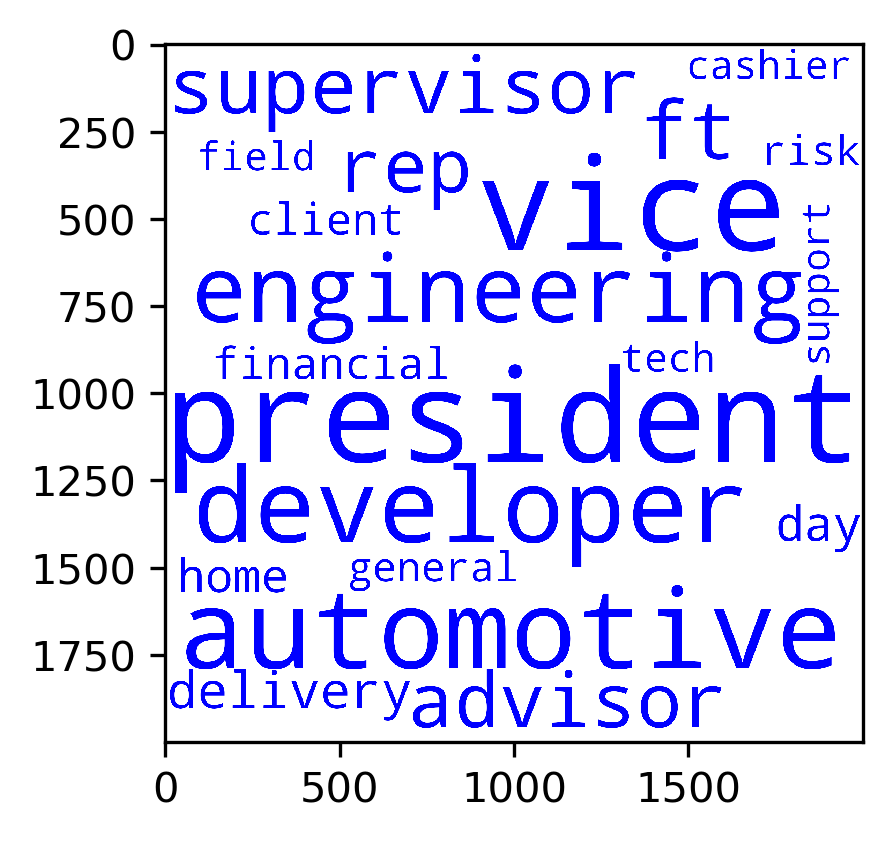

In [221]:
test = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", margin=0, width=2000, height=2000, color_func=lambda *args, **kwargs: "blue")
test.generate_from_frequencies(temp.head(20).to_dict())
fig = plt.figure(figsize=(6*0.5, 6) ,dpi=300)
ax = plt.subplot(111)
ax.imshow(test)
plt.axis('off')

## Slider bar word clouds

In [189]:
# Create figure
fig = go.Figure()

# Constants
img_width = 1800
img_height = 1800*0.75
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
fig.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

trace = go.Scatter(x=[0, img_width * scale_factor],
                   y=[0, img_height * scale_factor],
                   mode="markers",
                   marker_opacity=0)

layout = go.Layout(images=[go.layout.Image(
                                        x=0,
                                        sizex=img_width * scale_factor,
                                        y=img_height * scale_factor,
                                        sizey=img_height * scale_factor,
                                        xref="x",
                                        yref="y",
                                        opacity=1.0,
                                        layer="below",
                                        sizing="stretch",
                                        source='test.png')],
                   width=img_width * scale_factor,
                   height=img_height * scale_factor,
                   margin={"l": 0, "r": 0, "t": 0, "b": 0},
                   xaxis=dict(visible=False, range=[0, img_width * scale_factor]),
                   yaxis=dict(visible=False,range=[0, img_height * scale_factor],scaleanchor="x")
                  )

data = [trace]

fig = go.Figure(data=data, layout=layout)

py.plot(fig, auto_open=False)
s = py.plot(fig, include_plotlyjs=False, output_type='div')
py.iplot(fig)